In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn import _transpose_batch_time
from model import sampling_rnn

from datetime import datetime
import numpy as np
import pandas as pd
import copy
import time
import glob, os, sys

from helpers import get_sequences, iterate_minibatches, get_minibatches, check_game_roles_duplicates, \
                    process_moments
    
import matplotlib.pyplot as plt

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

%matplotlib inline

from utilities import LoadData, PlotGame, make_video
from helpers import id_player, id_position, id_teams, get_player_trajectory, segment
from model import rnn_horizon
# ---------------------------------------------------------
%load_ext autoreload
%autoreload 2

# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)

/home/sam/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/sam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# we will use this fixed order as the role order
roles = ['F', 'G', 'C-F', 'G-F', 'F-G', 'C', 'F-C']
role_order = {'F': 0, 'G':4, 'C-F':1, 'G-F':3, 'F-G':3, 'C':2, 'F-C':1}
# its possible that F has similar role as G-f or F-G, we create empty slots to ensure meta order

In [3]:
%%time
game_id = '0021500463'
game_data = Data.load_game(game_id)
events_df = pd.DataFrame(game_data['events'])

CPU times: user 10.8 s, sys: 176 ms, total: 11 s
Wall time: 10.7 s


In [4]:
print('events shape:', events_df.shape)
events_df.head(3)

events shape: (231, 8)


,end_time_left,home,moments,orig_events,playbyplay,quarter,start_time_left,visitor
0,702.31,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[0],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
1,686.28,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[1],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
2,668.42,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351444029, 692.25, 12.21, None, [[-1,...","[2, 3]",GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,692.25,"{'abbreviation': 'TOR', 'players': [{'playerid..."


In [5]:
# for i in events.moments[0]:
#     print(i[3], '|', i[5][0][2:])

### Let's just see the forward role model first, and ignore defending vs offending, use home vs visitor
### also ignore sequence length

In [6]:
id_role = id_position(events_df)
check_game_roles_duplicates(id_role)

0

In [7]:
events_df.loc[0].home['name']

'Chicago Bulls'

In [8]:
game_data['gamedate']

'2015-12-28'

In [9]:
len(events_df.loc[0,'moments'])

150

In [10]:
events_df['moments'].apply(lambda x: len(x)).values.min()

6

#### Pre-precoess input data

filter out actions except 1: Make, 2: Miss, 4: Rebound, 6:Personal Foul, 7:Violation

In [11]:
use_event = [1, 2, 4, 6, 7]
discard_event = [3, 5, 8, 9, 10, 12, 13, 18]
# events_df.loc[0, 'playbyplay'].to_dict('records')[0]

In [12]:
def filter_events(x, discard_event):
    etype = x['EVENTMSGTYPE'].values
    if len(set(etype).intersection(discard_event))!=0 or len(etype) ==0:
        # if the event contains discard events or if the event type is an empty list
        return False
    else:
        return True
    
events = events_df[events_df.playbyplay.apply(lambda x: filter_events(x, discard_event))].copy()
events.reset_index(drop=True, inplace=True)

In [13]:
events.shape

(134, 8)

Identify defending and offending runs (this is included in process_moments)

In [14]:
court_index = Data.load_csv('./meta_data/court_index.csv')
court_index = dict(zip(court_index.game_id, court_index.court_position))

split frames by shot clock 24s, re-order input according to role_order, extract trajectory

In [15]:
# %%time
homeid = events.loc[0].home['teamid']
awayid = events.loc[0].visitor['teamid']
single_game = []
sc = 24. # init 25s shot clock

# filter out seq length less than threshold
len_th = 25
n = 0
n_short = 0
s1 = 0
s2 = -1
for k, v in enumerate(events.moments.values):
    rec = []
    result_i = process_moments(v, homeid, awayid, id_role, role_order, court_index, game_id)
    if result_i == None:
        continue
    else:
        pm, scs = result_i
    for i in range(len(scs)-1):
        if scs[i] != None and scs[i+1] == None:
            if len(scs[s1:i+1]) >= len_th:
                single_game.append(pm[s1:i+1])
                n += 1
            else:
                n_short += 1
            s1 = i+1
        elif scs[i] == None:
            s1 += 1
        elif scs[i+1] > scs[i]:
            if len(scs[s1:i+1]) >= len_th:
                single_game.append(pm[s1:i+1])
                n += 1
            else:
                n_short += 1
            s1 = i+1
        elif scs[i+1] == scs[i] == sc:
            s1 += 1
    if s1 != len(scs)-2:
        if len(scs[s1:]) >= len_th:
            single_game.append(pm[s1:])
            n += 1
        else:
            n_short += 1
#         rec.append(scs[s1:])
        
    
# dimensions extreme<3> x n_players<10> x (player_pos<2> + teamid_onehot<25> + ball<3>) = 900

In [16]:
homeid

1610612741

In [17]:
awayid

1610612761

In [18]:
print(len(single_game))

183


In [19]:
# # %%time
# homeid = events.loc[0].home['teamid']
# awayid = events.loc[0].visitor['teamid']
# single_game = []
# sc = 24. # init 25s shot clock

# # filter out seq length less than threshold
# len_th = 10
# n = 0
# n_short = 0
# for k, v in enumerate(events.moments.values):
# #     print('>>>>>>>', k, end='\r')
#     pm, scs = process_moments(v, homeid, awayid, id_role, role_order)
#     print(scs)
#     rec = []
# #     break
#     s1 = 0 # shot clock reset index
#     for i in range(len(scs)-1):
#         if scs[i] == None: # somehow there is None shot clock
#             s1 += 1
#             continue
# #         if scs[i] >= sc and s1 != 0:
#         if scs[i] == scs[i+1] and scs[i] == sc:
#             s1 += 1
#             continue
# #         if scs[i] == None:
# #             print(v[i])
# #         print(scs[i], i, len(scs))
#         if scs[i] >= sc and s1 != 0: #and scs[i+1] < sc: # there are cases we have multiple 24 in a row 
# #             print('==============', pm[s1:i])
#             print('>>>>', scs[i], s1, '<<<<')
#             if len(pm[s1:i]) >= len_th:
#                 single_game.append(pm[s1:i-1])
#                 rec.append(scs[s1:i-1])
#                 n += 1
#             else:
#                 n_short += 1
#             s1 = i
#     if len(pm[s1:i]) >= len_th:
#         single_game.append(pm[s1:])
#         n += 1
#     else:
#         n_short += 1
    
#     print('>>>>', rec, '====')
        
#     break
# # dimensions extreme<3> x n_players<10> x (player_pos<2> + teamid_onehot<25> + ball<3>) = 900

In [20]:
print(n, n_short)

183 358


In [21]:
single_game[0].shape

(38, 210)

In [22]:
# lets first predict role F (ignored the extreme)
game_target = [np.roll(i[:, :2], -1, axis=0) for i in single_game]

In [23]:
single_game[0].shape

(38, 210)

In [24]:
game_target[0].shape

(38, 2)

In [25]:
single_game[1].shape

(0, 210)

#### Create train and test set

In [26]:
p = 0.8 # train percentage
divider = int(len(single_game)*p)
train_game, test_game = single_game[:divider], single_game[divider:]
train_target, test_target = game_target[:divider], game_target[divider:]

#### Build graph and starts training

In [27]:
tf.reset_default_graph()
# use training start time as the unique naming
train_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
logs_path = './train_logs/'

num_layers = 2
state_size = 256
batch_size = 64
dimx = 210
dimy = 2

n_epochs = 1000
# cell
lstm1 = tf.contrib.rnn.BasicLSTMCell(state_size, forget_bias=1.)
lstm2 = tf.contrib.rnn.BasicLSTMCell(state_size, forget_bias=1.)
lstm_cell = tf.contrib.rnn.MultiRNNCell([lstm1, lstm2])

# initial state
initial_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)

# input 
h = tf.placeholder(tf.int32)
X = tf.placeholder(tf.float32, [batch_size, None, dimx], name = 'train_input')
Y = tf.placeholder(tf.float32, [batch_size, None, dimy], name = 'train_label')
output, last_states = rnn_horizon(cell=lstm_cell, 
                                  initial_state=initial_state, 
                                  input_=X,
                                  batch_size=batch_size,
                                  seq_lengths=h,
                                  output_dim=dimy)
# output as the prediction
print('output shape, last_states', output.shape, last_states)
pred = output
print('label shape:{0:} | output prediction shape: {1:}'.format(Y.shape, pred.shape))

# Tensorboard's Graph visualization more convenient
with tf.name_scope('MSEloss'):
    # loss
    loss = tf.losses.mean_squared_error(Y, pred)
with tf.name_scope('Adam'):
    # optimzier
    opt = tf.train.AdamOptimizer().minimize(loss)
    
# Initialize variables
init = tf.global_variables_initializer()
# Create a summary to monitor cost tensor
train_summary = tf.summary.scalar("TrainMSEloss", loss)
valid_summary = tf.summary.scalar("ValidMSEloss", loss)
# # Merge all summaries into a single op
# merged_summary_op = tf.summary.merge_all()


# session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Initializing the variables
sess.run(init)
# op to write logs to Tensorboard
train_writer = tf.summary.FileWriter(logs_path+'/train'+train_time, graph=tf.get_default_graph())
valid_writer = tf.summary.FileWriter(logs_path+'/valid'+train_time, graph=tf.get_default_graph())

# iterate
printn = int(1e2)
# horizon = [2, 4, 8, 12, 16, 20, 25]
horizon = range(2, 8)
t_int = time.time()
train_step = 0
valid_step = 0
for k in horizon:
    # look-ahead horizon
#     seq_len = k + 1
    seq_len = k
    print('Horizon {0:} {1:}'.format(seq_len, '='*10))

    # train x
    train_x = copy.deepcopy([get_sequences(i, seq_len, dimx) for i in train_game])
    train_x = copy.deepcopy(np.concatenate(train_x, axis=0))
    print('train_x.shape:', train_x.shape)
    # train y
    train_y = copy.deepcopy([get_sequences(i, seq_len, dimy) for i in train_target])
    train_y = copy.deepcopy(np.concatenate(train_y, axis=0))
    print('train_y.shape:', train_y.shape)
    
    # valid x
    val_x = copy.deepcopy([get_sequences(i, seq_len, dimx) for i in test_game])
    val_x = copy.deepcopy(np.concatenate(val_x, axis=0))
    print('valid_x.shape:', val_x.shape)
    # valid y
    val_y = copy.deepcopy([get_sequences(i, seq_len, dimy) for i in test_target])
    val_y = copy.deepcopy(np.concatenate(val_y, axis=0))
    print('valid_y.shape:', val_y.shape)
    
    for epoch in range(n_epochs):
        epoch_loss =0.
        n_train_batch = train_x.shape[0]//batch_size
        t1 = time.time()
        for batch in iterate_minibatches(train_x, train_y, batch_size, shuffle=False):
            train_xi, train_yi = batch
            p, l, _, train_sum = sess.run([output, loss, opt, train_summary], 
                                        feed_dict={X: train_xi, Y: train_yi, h:seq_len})
            train_writer.add_summary(train_sum, train_step)
            epoch_loss += l/n_train_batch
            train_step += 1
        # print out info
        if epoch%printn ==0:
            n_val_batch = val_x.shape[0]//batch_size
            t2 = time.time()
            valid_loss = 0
            for batch in iterate_minibatches(val_x, val_y, batch_size, shuffle=False):
                val_xi, val_yi = batch
                val_l, valid_sum = sess.run([loss, train_summary], 
                                            feed_dict={X: val_xi, Y: val_yi, h:seq_len})
                valid_writer.add_summary(valid_sum, valid_step)
                valid_loss += val_l/n_val_batch
                valid_step += printn
            print('Epoch {0:<4d} | loss: {1:<8.2f} | time took: {2:<.2f}s '
                  '| validation loss: {3:<8.2f}'.format(epoch, epoch_loss, (t2-t1), valid_loss))
                

t_end = time.time()
print('Total time took: {0:<.2f}hrs'.format((time.time()-t_int)/60/60))
# sess.close()
# # save model
# #Create a saver object which will save all the variables
# saver = tf.train.Saver()
# #save the graph
# saver.save(sess, save_path='./models/test_model')

output shape, last_states (64, ?, 2) (LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(64, 256) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(64, 256) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_6:0' shape=(64, 256) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_7:0' shape=(64, 256) dtype=float32>))
label shape:(64, ?, 2) | output prediction shape: (64, ?, 2)
Horizon 2 ==========
train_x.shape: (3457, 2, 210)
train_y.shape: (3457, 2, 2)
valid_x.shape: (971, 2, 210)
valid_y.shape: (971, 2, 2)
Epoch 0    | loss: 136.65   | time took: 0.29s | validation loss: 63.11   
Epoch 100  | loss: 6.60     | time took: 0.14s | validation loss: 32.12   
Epoch 200  | loss: 3.64     | time took: 0.14s | validation loss: 19.49   
Epoch 300  | loss: 3.81     | time took: 0.14s | validation loss: 18.09   
Epoch 400  | loss: 2.92     | time took: 0.14s | validation loss: 16.84   
Epoch 500  | loss: 1.60     | time took: 0.14s | validation loss: 15.36   
Epoch 600  | loss: 3

### Check model on train set

check_id: 44


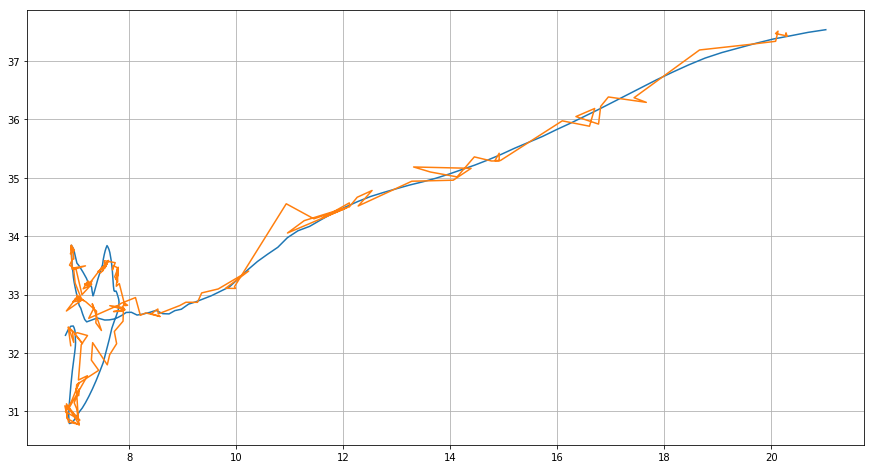

In [32]:
check_seq_len = 3

# use while loop to make sure the 
present = 0
while present == 0:
    check_ind = np.random.randint(0, len(train_game)-1)
    # check_ind = 0
#     print('check_id:', check_ind)
    input_x = copy.deepcopy(get_sequences(train_game[check_ind], check_seq_len, dimx))
#     print('input x shape >>>', input_x.shape)
    output_y = copy.deepcopy(get_sequences(train_target[check_ind], check_seq_len, dimy))
    if input_x.shape[0] >= batch_size:
        print('check_id:', check_ind)
        present += 1

pred = []
y_train = []
order_x = []
for batch in iterate_minibatches(input_x, output_y, batch_size, shuffle=False):
    input_xi, output_yi = batch
    p = sess.run([output], feed_dict={X: input_xi, h:check_seq_len})#, Y: train_yi, h:2})
    pred.append(p)
    order_x.append(input_xi)
    y_train.append(output_yi)
pred_train = np.array(pred).reshape(-1,2)
y_train = np.array(y_train).reshape(-1,2)
plt.figure(figsize=(15,8))
plt.plot(y_train[:,0], y_train[:,1], pred_train[:, 0], pred_train[:, 1])
plt.grid(True)

#### Check model on test set

check_id: 21
(118, 3, 210) (118, 3, 2)


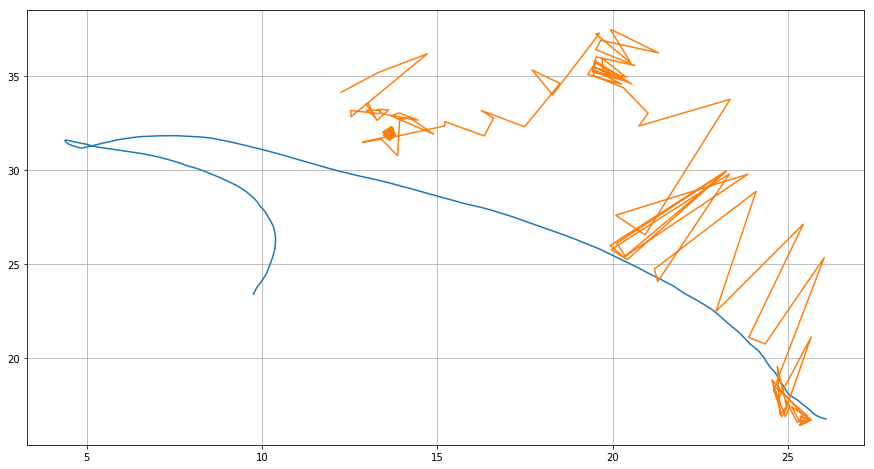

In [29]:
check_seq_len = 3

# use while loop to make sure the 
present = 0
while present == 0:
    check_ind = np.random.randint(0, len(test_game)-1)
    # check_ind = 0
#     print('check_id:', check_ind)
    input_x = copy.deepcopy(get_sequences(test_game[check_ind], check_seq_len, dimx))
#     print('input x shape >>>', input_x.shape)
    output_y = copy.deepcopy(get_sequences(test_target[check_ind], check_seq_len, dimy))
    if input_x.shape[0] >= batch_size:
        print('check_id:', check_ind)
        present += 1

pred = []
y_train = []
order_x = []
print(input_x.shape, output_y.shape)
for batch in iterate_minibatches(input_x, output_y, batch_size, shuffle=False):
    input_xi, output_yi = batch
    p = sess.run([output], feed_dict={X: input_xi, h:check_seq_len})#, Y: train_yi, h:2})
    pred.append(p)
    order_x.append(input_xi)
    y_train.append(output_yi)
pred_train = np.array(pred).reshape(-1,2)
y_train = np.array(y_train).reshape(-1,2)
plt.figure(figsize=(15,8))
plt.plot(y_train[:,0], y_train[:,1], pred_train[:, 0], pred_train[:, 1])
plt.grid(True)

#### Create video based off predictions

In [30]:
# events.head()
# replace the true position with the predicted
events_pred = events.head(1).copy()
def replace_pos(x):
    for i in range(len(pred_train)):
#         print(x[i][5])
#         print(x[i][5][2][2:4], pred_train[i])
        x[i][5][2][2:4]=pred_train[i] 
events_pred = events_pred.moments.apply(lambda x: replace_pos(x))

IndexError: list index out of range

In [ ]:
# save all moments for a specific events
Plot = PlotGame(game_id, main_dir, game_dir)
moments = range(len(pred_train))
event_number = 0
for i in moments:
    print(i, end='\r')
    Plot.load_pred_moment2img(game_data, event_number, i)
# PlotGame.load_pred_moment2img()

In [ ]:
#  so by comparing the position we know we are modelling the third position ind = 2
# order_x

In [ ]:
# prepare to save videos
event_dir = game_dir + 'game' + str(game_id) + '/' + 'predevent' + str(event_number) + '/'
video_name = event_dir + str(event_number) + '.mp4'
print(video_name)
images = glob.glob(event_dir + "*.png")
images = sorted(images, key=lambda x: int(x.split('.')[2].split('/')[-1][4:]))
# print(images)
# save to video
make_video(images, video_name, 15)

In [ ]:
pred_train.shape

In [ ]:
# len(events_pred.moments)

### To do:

    - 1) Regularize the lstm
    - 2) Figure out why there are blanks in the testing
    - 3) may consider to collect those left out from the process of creating batches
    - 4) related to 3), seq_len = 3 may create null batches 

    - Split data to defending and offending, as the model for e.g. forward role in deffending and offending should be pretty different. Remove particular events, like free-throw etc.
    
    - We can use the shot clock as an indicator of when the offending and defending switches.
    
    - The cameras oprate at 25 frames per second, so in order to learn realistic motions, either we sample the 25 frames, or extend the horizon to 50 for example or even longer(this might be too computationally heavy and model would probably drift a lot).
    
    - At the moment if we don't have defending or offending sepearted, at least we need to break down the sequences from the 24 secs shot clock, since it usually stands for a change in game state. (note: shot clock sometimes is None)
    
    - Add tensorboard visualization. Add validation performance (maybe, it would take longer). 
      tensorboard --logdir=./train_logs
      
    - Start thinking about 1) joint training 2) Hidden structure 3) Smooth learning

### Questions

    * After a team scored and they go back to get ready for defense, is the going back trajectory pretty much random?
    * Do player swap roles during the play? e.g. a forward swapped to a guard, is the forward roles a lot different from gaurds these day? (i.e. can you differentaite a player plaing forward from guard from the game) If yes, then the hidden structure learning/sequencing is necessary. 